<a href="https://colab.research.google.com/github/JMGO-coding/MLX_academic_performance/blob/develop/src/dt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***PROJECT TASK***

The goal of practical project is to explain, using all techniques explained in class, the ML
models assigned.
At least each team must explain 2 ML models (a.k.a. compulsory models). Additionally,
the team can build and explain a third model (a.k.a. extra model).

The Practical Project will consist of:

- Python 2 or 3 notebooks: ipynb file for each model.
- Dataset: csv file or online load hardcoded.

Each notebook must include:

- Markdown use:
    - Sections and subsections numbered (using #, ##, etc.)
    - Concise and clear descriptions of the decisions made
    - Concise and clear conclusions of the explanations obtained.

- The code must be clear and must include comments.
- The notebook must include 3 sections (you can add subsections):

1. Dataset load and preparation
2. ML model training
3. ML explanation

The ML explanation, section 3, is the most important part of the project. Here you should
cover:

- Use any explanation method useful that you’ve seen on class.
- Provide individual explanations of instance. Not just plots, but the conclusions
you can make.
- Provide global explanations of the ML model. Not just plots, but the conclusions
you can make.

# Machine Learning Explicable. Explicación de un Decision Tree.

## 0. Requerimientos y funciones auxiliares

In [1]:
%%capture

COLAB = True # TODO: True para ejecutar notebook en Colab
INSTALL = COLAB # TODO: True para instalaciones en Colab

if INSTALL:
    %pip install supertree
    %pip install dill

In [2]:
CLONE = COLAB
if CLONE:
  !git clone https://github.com/JMGO-coding/MLX_academic_performance.git

Cloning into 'MLX_academic_performance'...
remote: Enumerating objects: 172, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 172 (delta 78), reused 36 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (172/172), 24.40 MiB | 2.92 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [3]:
# Importación de librerías
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math
#import supertree

import os
import sys
import datetime

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
#from skopt import BayesSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import OneHotEncoder
import sklearn.impute as impute

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import plot_tree

from sklearn.pipeline import Pipeline
from scipy import stats

# Regresión

# Preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

from sklearn.decomposition import PCA

# Desbalanceo
#from imblearn.over_sampling import SVMSMOTE, RandomOverSampler, ADASYN
#from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour
#from imblearn.ensemble import RUSBoostClassifier
#from sklearn.svm import OneClassSVM

# Modelos de clasificación

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBRegressor
# import joblib
import dill


# TODO: Explicabilidad: SHAP, LIME
import shap

In [4]:
# Añadir los directorio fuentes al path de Python
if COLAB:
  sys.path.append('/content/MLX_academic_performance/src')
else:
  sys.path.append('./src')

In [5]:
def save_model(model, model_path):
    with open(model_path, "wb") as f:
        dill.dump(model, f)

In [6]:
def load_model(model_path):
    with open(model_path, "rb") as f:
        return dill.load(f)

## 1. Carga y preprocesamiento del dataset

### 1.1. Primeras visualizaciones y estadísticas

In [7]:
# Fijamos la semilla y los directorios

SEED = 2024
directory = '/content/MLX_academic_performance' if COLAB else '../'
plots_directory = os.path.join(directory, 'plots/')
data_directory = os.path.join(directory, 'data/')

LOAD = True # True para cargar el modelo ya entrenado

if COLAB:
  model_path = '/content/MLX_academic_performance/models/dt.pkl' # Ruta del modelo que se guarda/carga
else:
  model_path = './models/dt.pkl' # Ruta del modelo que se guarda/carga

Usamos el dataset *Predict Students' Dropout and Academic Success*, creado por una institución portuguesa de educación superior, que contiene información sobre estudiantes matriculados en diferentes licenciaturas (como agronomía, diseño, educación, enfermería, periodismo, gestión, servicios sociales o tecnología). El objetivo principal es predecir el abandono y el éxito académico de los estudiantes mediante modelos de clasificación.

Incluye información demográfica, socioeconómica y académica del estudiante al momento de la matrícula, así como su rendimiento académico al final del primer y segundo semestre. El problema se formula como una tarea de clasificación de tres categorías: abandono, matriculado y graduado, al final de la duración normal del curso.

In [8]:
# Lectura del Dataset y primera visualización

data_file = 'data.csv'
data_path = data_directory + data_file
df= pd.read_csv(data_path, sep=';')
print(df.shape)
df.head()

(4424, 37)


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [9]:
# Limpiar los nombres de las columnas
df.columns = df.columns.str.strip()  # Eliminar espacios al principio y al final

In [10]:
df.info()   # Conteo de no-nulos y data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance                      4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

El dataset no contiene valores nulos. Además, hay 29 columnas con tipo de dato `int64` representando variables categóricas y  variables numéricas discretas, 7 columnas de tipo `float64` representando variables numéricas continuas, como calificaciones y tasas, y una columna de tipo `object` que representa la variable objetivo y contiene las categorías de clasificación (abandono, matriculado y graduado).

In [11]:
df.describe()   # Estadísticos básicos sobre los features numéricos del dataset

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


Para facilitar el preprocesamiento y el estudio de las variables, las separamos en distintas listas según su tipo.

In [12]:
# Variables según su tipo
qualification_features = ['Previous qualification', 'Mother\'s qualification', 'Father\'s qualification']
thres_features = ['Marital status', 'Application mode', 'Course', 'Mother\'s occupation', 'Father\'s occupation']

categorical_features = thres_features + qualification_features + ['Nacionality']   # Variables categóricas

numerical_features = ['Application order', 'Previous qualification (grade)',
                      'Admission grade', 'Age at enrollment',
                      'Curricular units 1st sem (credited)',  'Curricular units 1st sem (enrolled)',  'Curricular units 1st sem (evaluations)',
                      'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)',  'Curricular units 1st sem (without evaluations)',
                      'Curricular units 2nd sem (credited)',  'Curricular units 2nd sem (enrolled)',  'Curricular units 2nd sem (evaluations)',
                      'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)',  'Curricular units 2nd sem (without evaluations)',
                      'Unemployment rate', 'Inflation rate', 'GDP'
                    ]   # Variables numéricas

binary_features = ['Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender',
                   'Scholarship holder', 'International']   # Variables binarias

target_feature = 'Target' # Variable objetivo, categórica con 3 clases

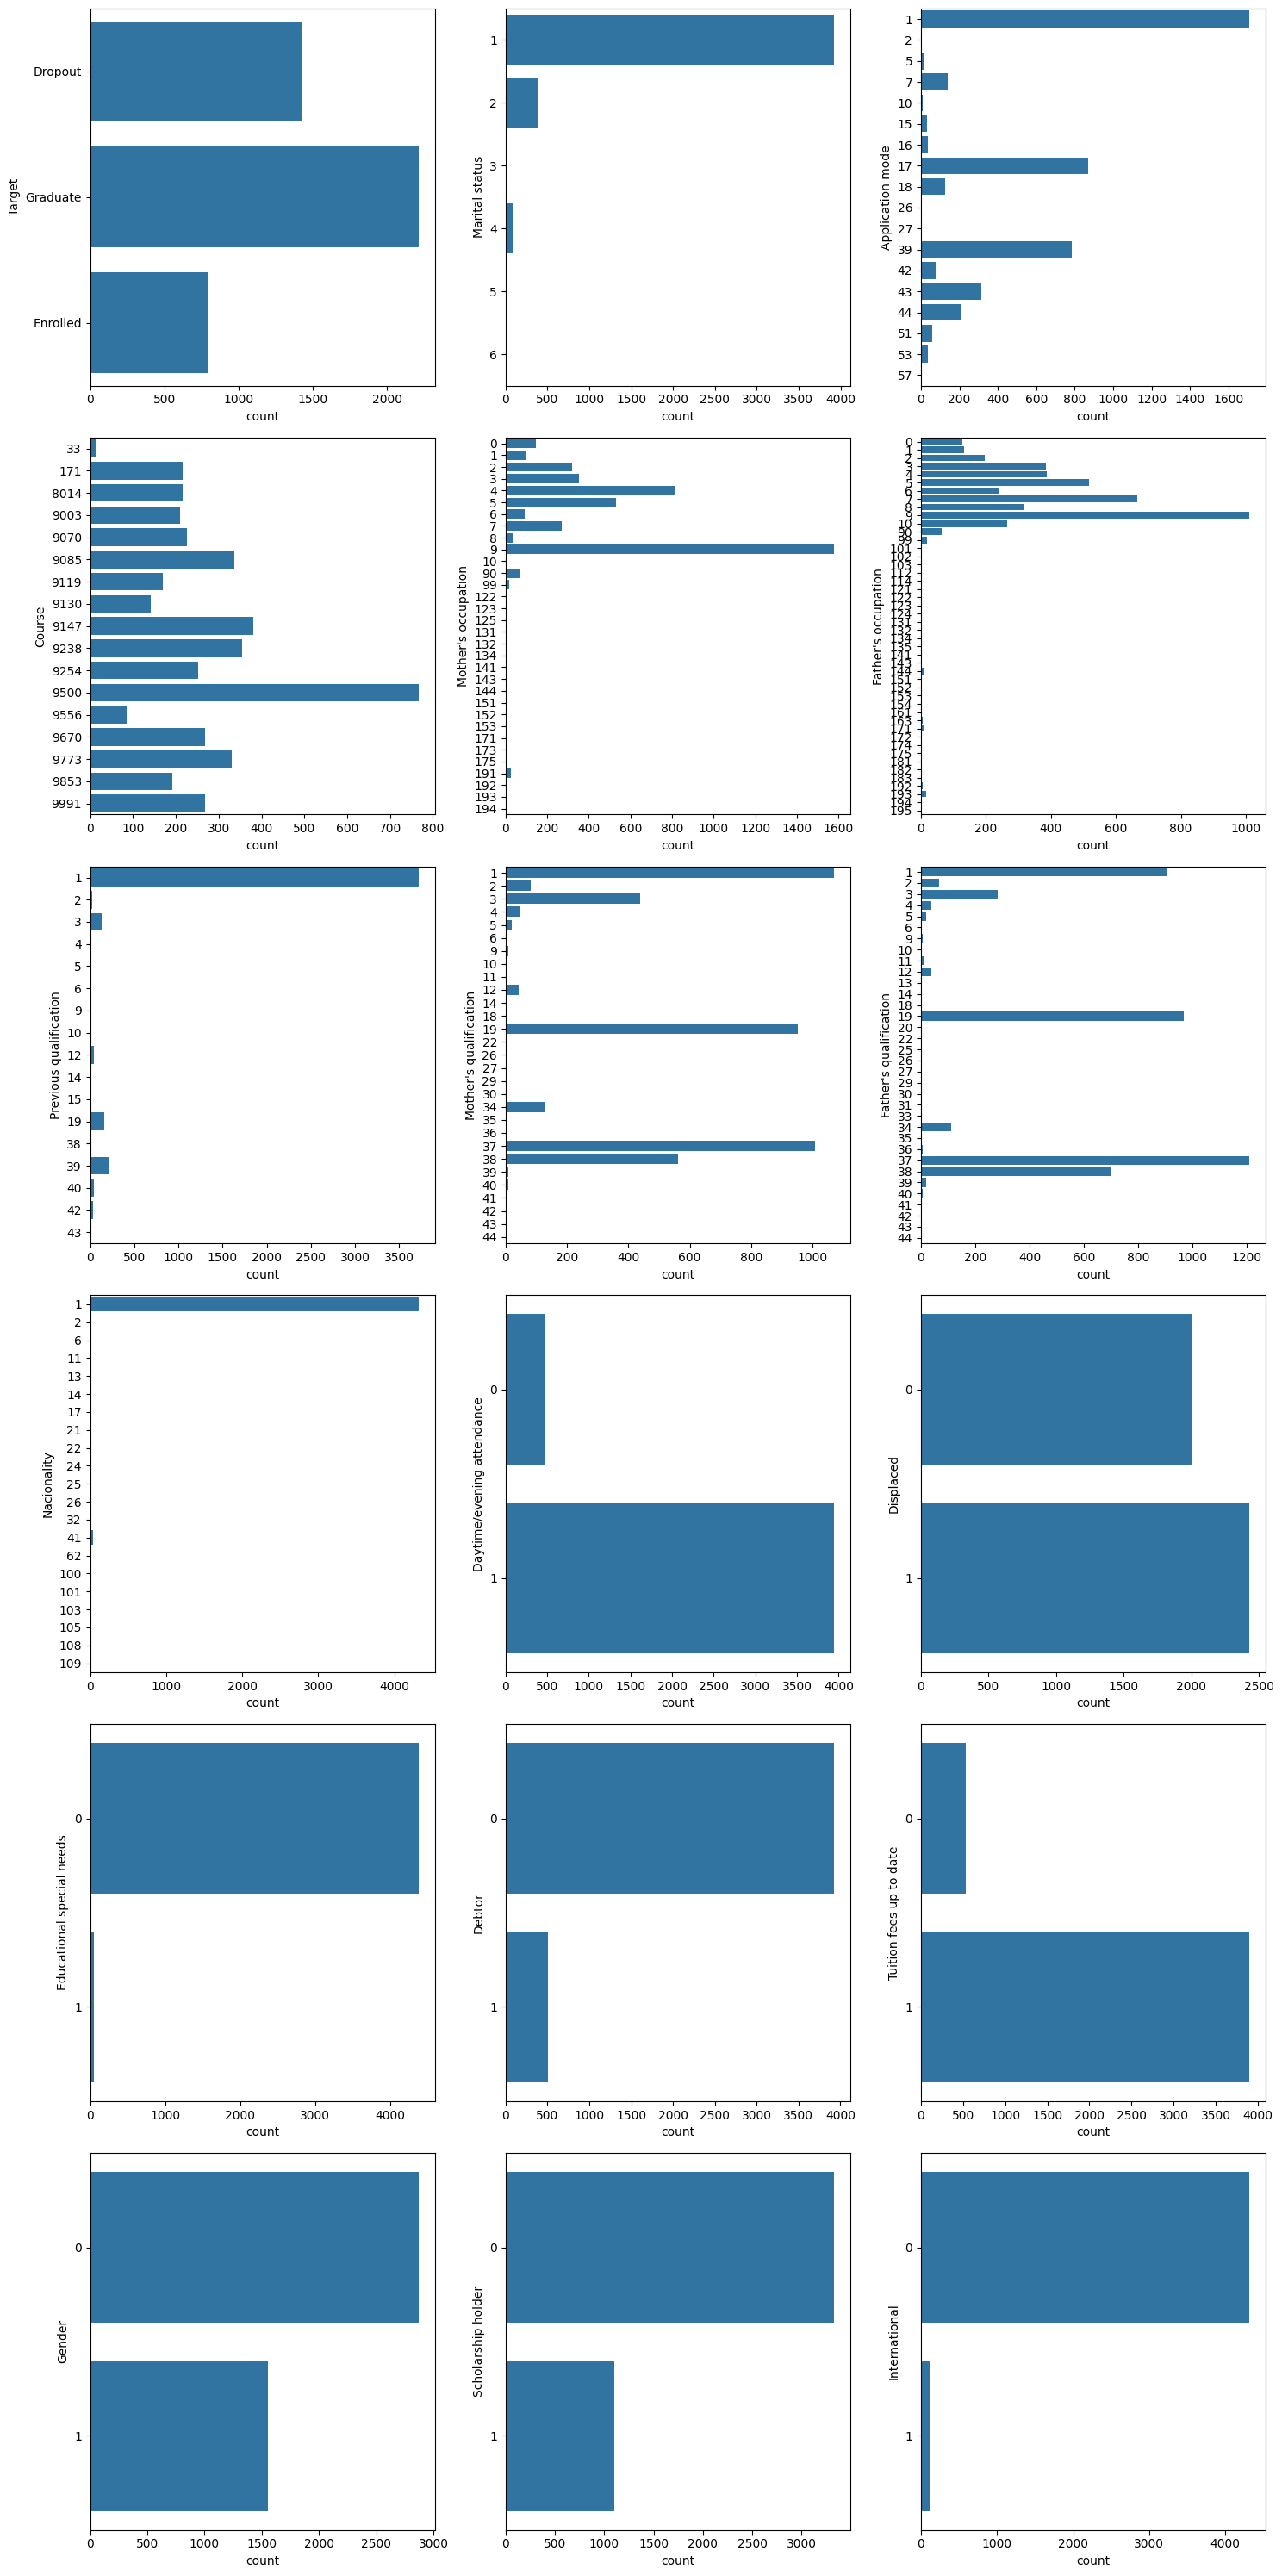

In [13]:
# Histograma variables categóricas

# Calculate number of rows needed for 3 columns
num_features = len([target_feature] + categorical_features + binary_features)
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))  # Adjust figsize as needed

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate through features and plot
feature_index = 0
for feature in [target_feature] + categorical_features + binary_features:
    sns.countplot(y=feature, data=df, ax=axes[feature_index])  # Plot on the current subplot
    feature_index += 1

# Remove empty subplots if any
for i in range(feature_index, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Observando el histograma para la variable `Target` vemos que hay desequilibrio entre las clases, con una mayor cantidad de graduados, y menor de matriculados.

### 1.2. Selección de características

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

selection = False # True para realizar selección de características

selected_features = categorical_features + numerical_features + binary_features

if selection:
    # Definir variables predictoras y objetivo
    X = df.drop(columns=['Target']).copy()  # Reemplaza 'target' con el nombre de tu variable objetivo
    y = df['Target'].copy()

    # Dividir en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # Estandarización de los datos (opcional, útil para algunos modelos)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Construir el modelo de Random Forest
    rf = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
    rf.fit(X_train, y_train)

    # Evaluar modelo
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.4f}')

    # Obtener la importancia de las características
    feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)

    # Visualizar las características más importantes
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
    plt.xlabel("Importancia")
    plt.ylabel("Característica")
    plt.title("Importancia de las características en Random Forest")
    plt.gca().invert_yaxis()
    plt.show()

    # Selección de características más importantes (puedes ajustar el umbral)
    selected_features = feature_importances[feature_importances['importance'] > 0.02]['feature'].tolist()

print("Características seleccionadas:", selected_features)

Características seleccionadas: ['Marital status', 'Application mode', 'Course', "Mother's occupation", "Father's occupation", 'Previous qualification', "Mother's qualification", "Father's qualification", 'Nacionality', 'Application order', 'Previous qualification (grade)', 'Admission grade', 'Age at enrollment', 'Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)', 'Unemployment rate', 'Inflation rate', 'GDP', 'Daytime/evening attendance', 'Displaced', 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender', 'Scholarship holder', 'Internat

In [15]:
# Filtramos las listas de features tras la seleccion

selected_features += ['Target'] # Añadimos el target

qualification_features = [feat for feat in selected_features if feat in qualification_features]
thresh_features = [feat for feat in selected_features if feat in thres_features]
categorical_features = [feat for feat in selected_features if feat in categorical_features]
numerical_features = [feat for feat in selected_features if feat in numerical_features]
binary_features = [feat for feat in selected_features if feat in binary_features]

### 1.3. Transformación de variables categóricas

En este apartado del preprocesamiento, aplicamos una serie de transformaciones a las variables categóricas del dataset, para facilitar la construcción del modelo. Algunas de estas variables contienen un gran número de categorías, por lo que para poder tratarlas de forma más eficiente, se van a agrupar dichas categorías en un menor número de categorías más generales.

En primer lugar, definimos una función `transformar_nivel_estudios`, que utilizamos para agrupar todas las categorías relacionadas con el nivel de estudios del estudiante y de sus padres en cuatro grupos más generales: "Incompleta", "Secundaria", "Superior Técnica" y "Universitaria".

In [16]:
def transformar_nivel_estudios(valor):
    """
    Transforma el nivel de estudios de un número entero a una de las cuatro nuevas categorías.
    """
    no_secundaria = {11, 26, 27, 38, 19, 12, 14, 15, 10, 9, 6, 29, 30, 35, 36, 37, 13, 20, 25}
    secundaria_completa = {1}
    superior_tecnico = {22, 39, 42, 18, 31, 33}
    superior_universitario = {2, 3, 4, 5, 40, 43, 44, 41}

    if valor in no_secundaria:
        return "Incompleta"
    elif valor in secundaria_completa:
        return "Secundaria"
    elif valor in superior_tecnico:
        return "Superior Técnica"
    elif valor in superior_universitario:
        return "Universitaria"
    else:
        return "Otro"

In [17]:
qualification_features = ['Previous qualification', 'Mother\'s qualification', 'Father\'s qualification']

for feature in qualification_features:
    df[feature] = df[feature].apply(transformar_nivel_estudios)

A continuación, como la variable `Nacionality` también contiene muchas categorías diferentes, y además la mayoría de ellas están representadas por un número muy reducido de instancias, hemos decidido cambiarla por una variable binaria llamada `foreign`. En esta nueva variable, 0 indica que el estudiante es de nacionalidad portuguesa y 1 que es extranjero.

In [18]:
# Transformar variables enteras a categóricas
df['Nacionality'] = df['Nacionality'].astype('category')
df['foreign'] = df['Nacionality'].map(lambda x: 0 if x == 1 else 1)

if 'Nacionality' in selected_features:
  selected_features.remove('Nacionality')
  selected_features += ['foreign']

  binary_features += ['foreign']
  categorical_features.remove('Nacionality')

df.drop(columns=['Nacionality'], inplace=True)

Para manejar aquellas categorías con baja frecuencia, en algunas columnas categóricas se ha usado un umbral del $5\%$ para agrupar las categorías con frecuencias muy bajas en una categoría general -1 (equivale a una clase ``otro''). Gracias a este paso, disminuimos el número de categorías en dichas variables.

In [19]:
# 5% threshold for categorical features

threshold = 0.05

for feature in thres_features:
    value_counts = df[feature].value_counts(normalize=True)
    if value_counts.max() > threshold:
        df[feature] = df[feature].apply(lambda x: x if value_counts[x] > threshold else -1) # -1 = other

Por último, creamos histogramas para observar la nueva distribución de las variables categóricas tras haber realizado las transformaciones.

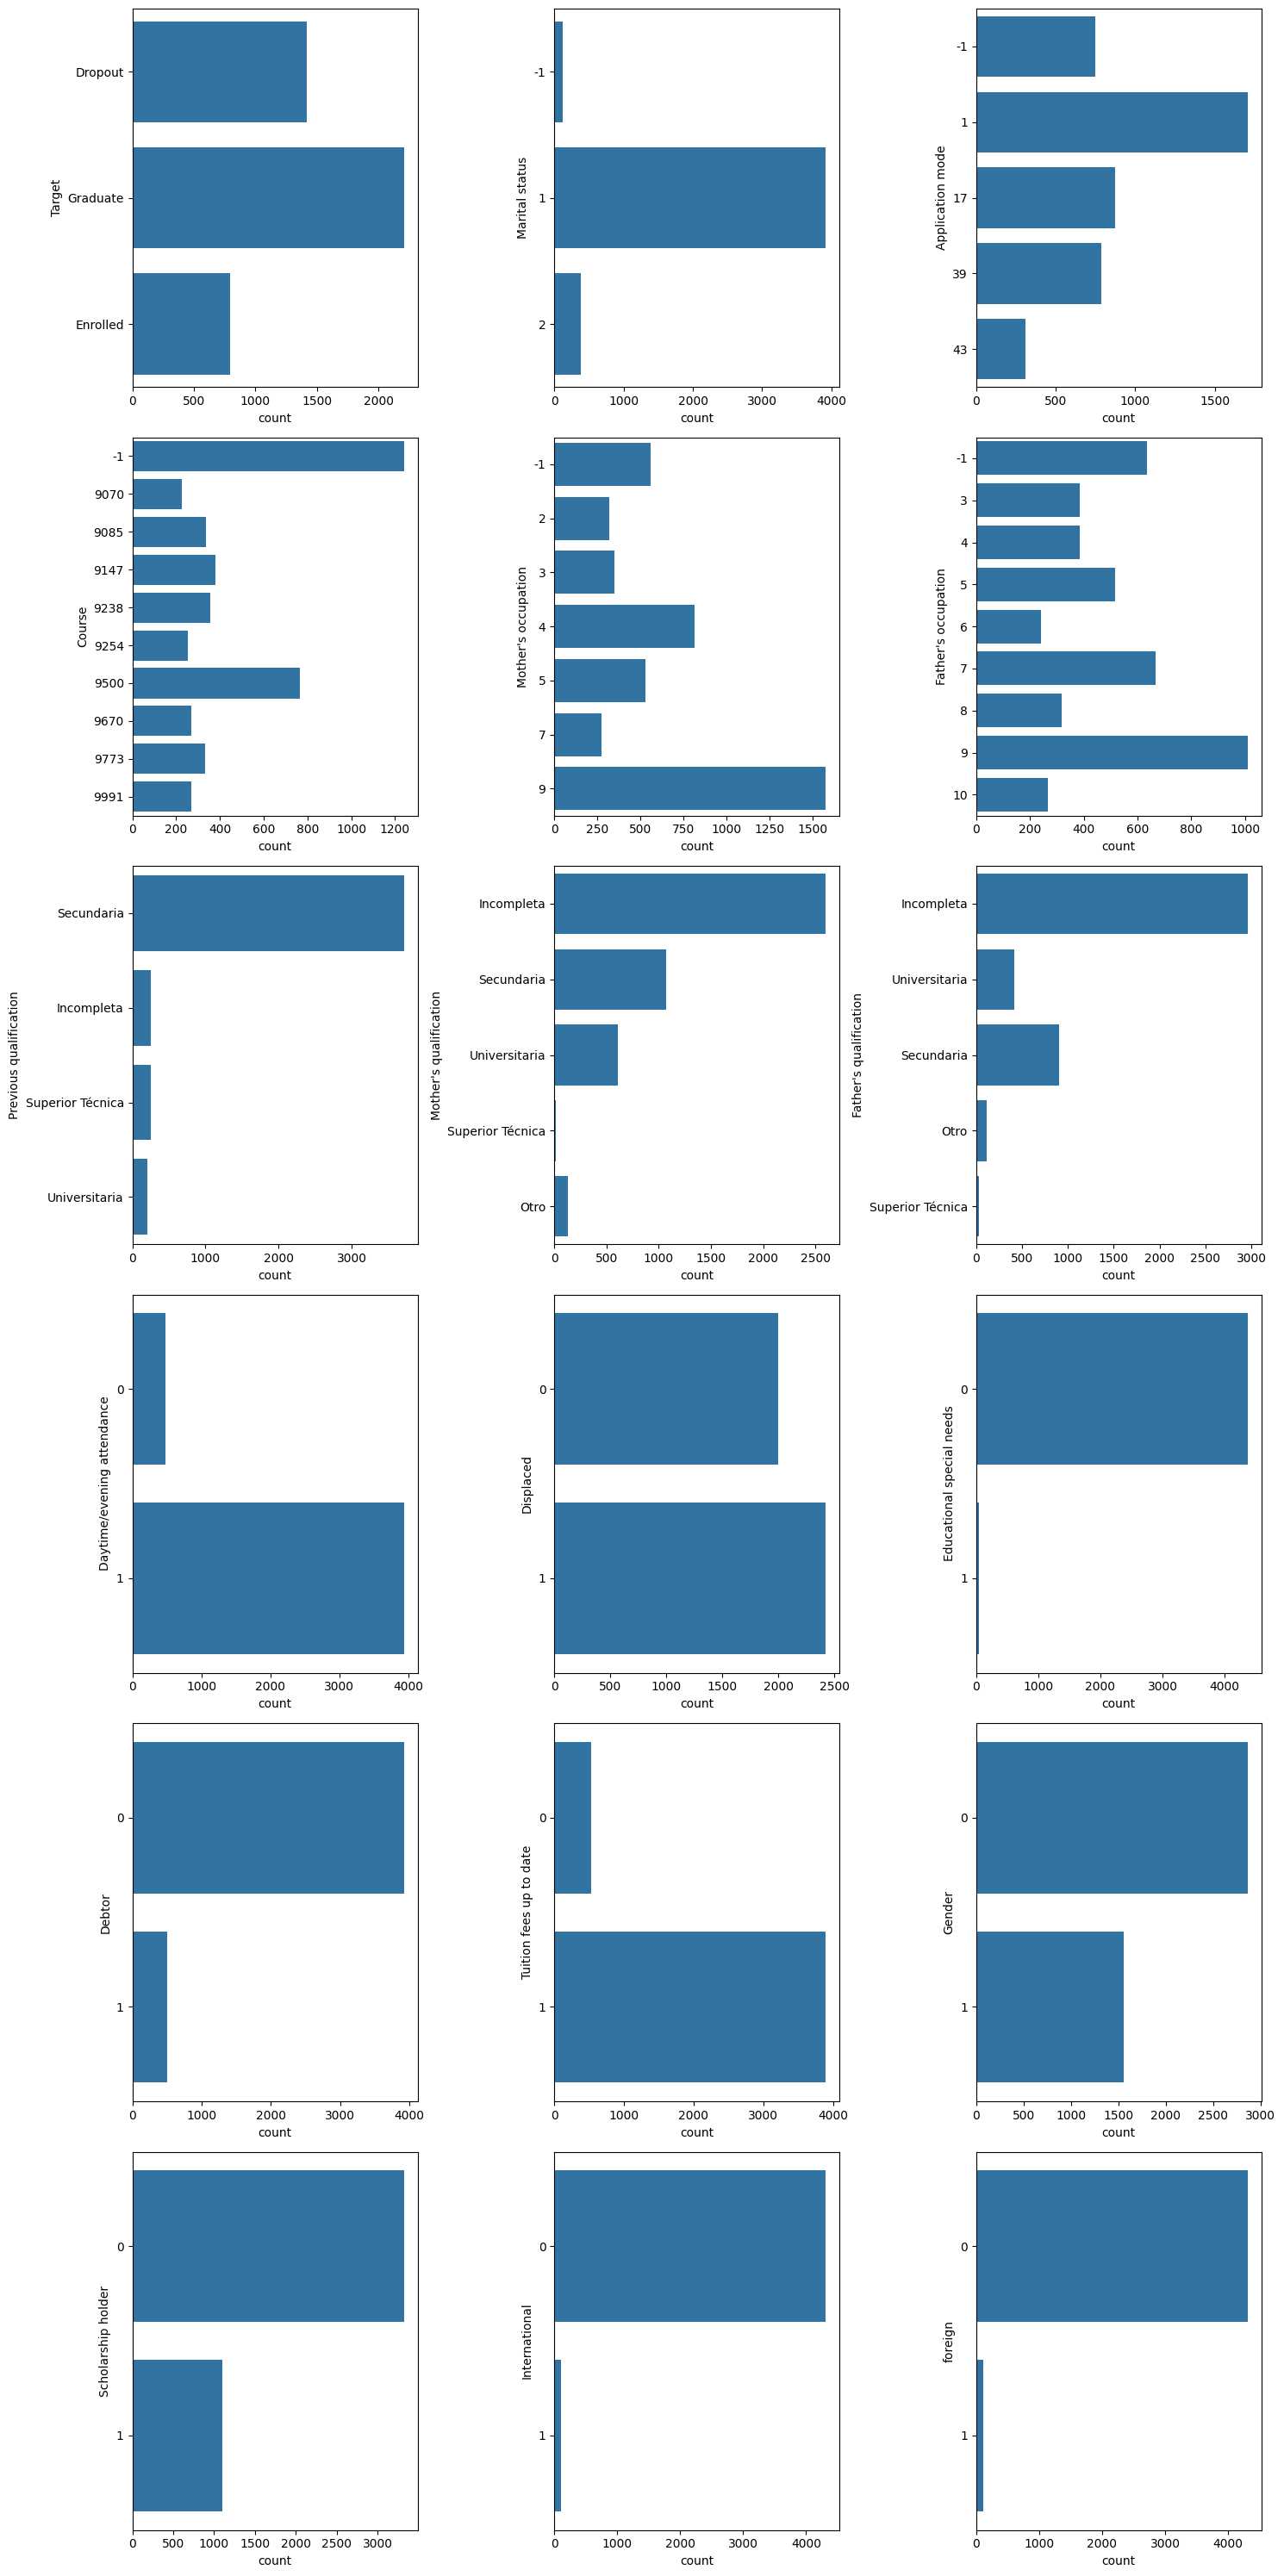

In [20]:
# Histograma variables categóricas

# Calculate number of rows needed for 3 columns
num_features = len([target_feature] + categorical_features + binary_features)
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

# Create the figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))  # Adjust figsize as needed

# Flatten axes for easier iteration
axes = axes.flatten()

# Iterate through features and plot
feature_index = 0
for feature in [target_feature] + categorical_features + binary_features:
    sns.countplot(y=feature, data=df, ax=axes[feature_index])  # Plot on the current subplot
    feature_index += 1

# Remove empty subplots if any
for i in range(feature_index, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Ahora, se convierten las variables categóricas a tipo `category`.

In [21]:
for feature in categorical_features:
    df[feature] = df[feature].astype('category') # other

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype   
---  ------                                          --------------  -----   
 0   Marital status                                  4424 non-null   category
 1   Application mode                                4424 non-null   category
 2   Application order                               4424 non-null   int64   
 3   Course                                          4424 non-null   category
 4   Daytime/evening attendance                      4424 non-null   int64   
 5   Previous qualification                          4424 non-null   category
 6   Previous qualification (grade)                  4424 non-null   float64 
 7   Mother's qualification                          4424 non-null   category
 8   Father's qualification                          4424 non-null   category
 9   Mother's occupation           

### 1.3. Variables numéricas

A continuación, visualizamos las distribuciones de las variables numéricas utilizando histogramas y curvas de densidad.

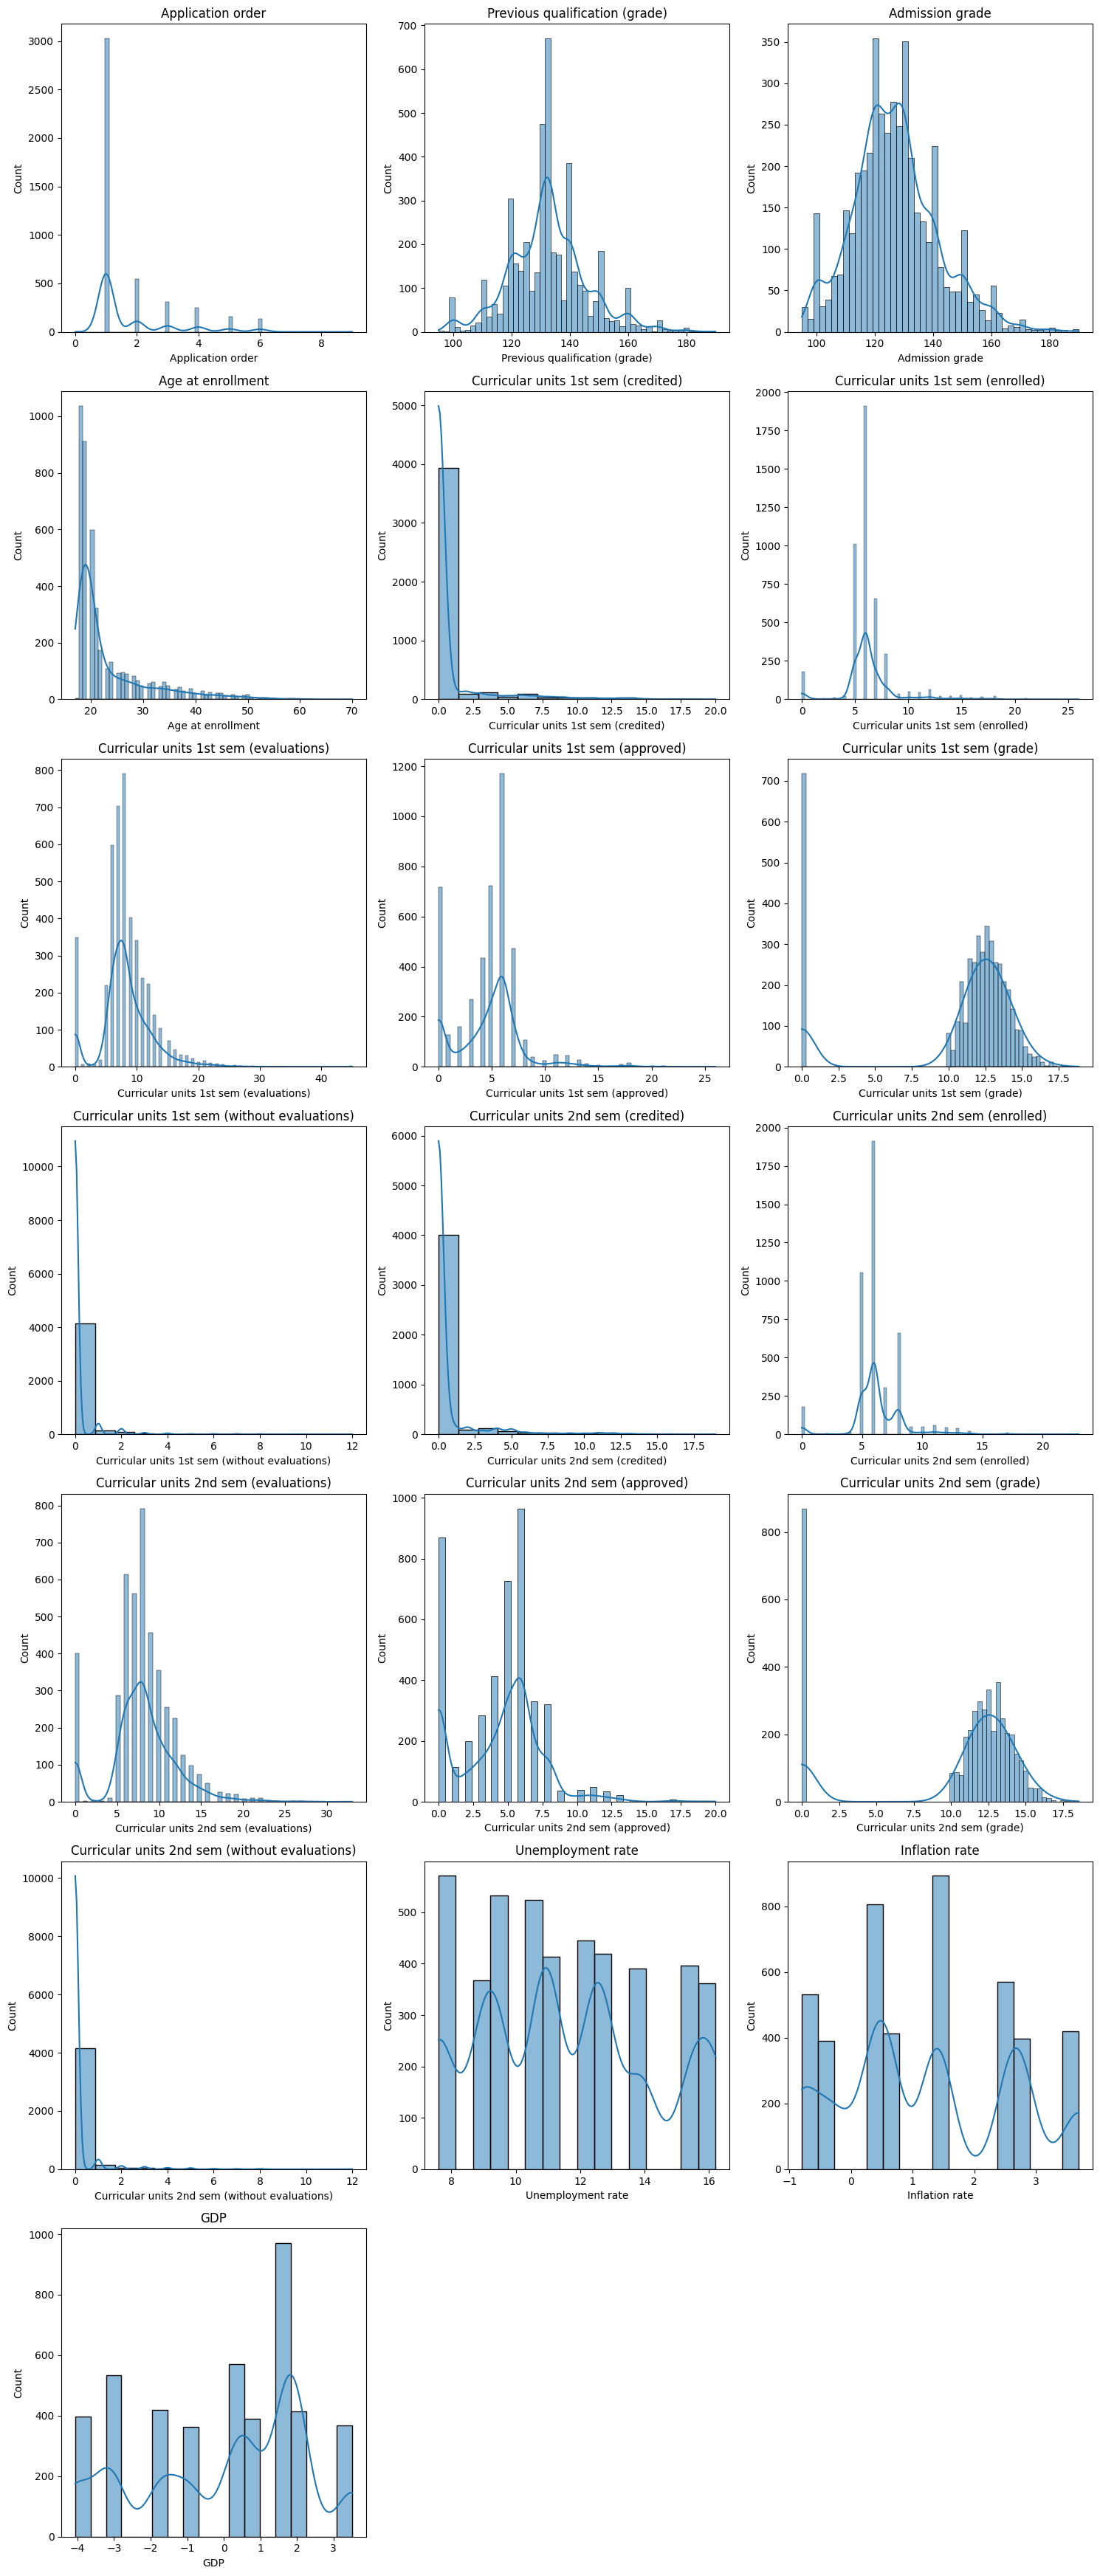

In [23]:
# Lista de características numéricas

# Definir el número de columnas y calcular el número de filas
num_cols = 3
num_rows = math.ceil(len(numerical_features) / num_cols)

# Crear la figura y los ejes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Aplanar para facilitar la iteración

# Graficar cada característica
for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], kde=True, ax=axes[i])
    axes[i].set_title(feature)

# Eliminar ejes vacíos si hay
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 1.4. Partición de los datos en *Train* y *Test*

Particionamos los datos en un conjunto de *train* del $90\%$ que usaremos para entrenar el modelo, y un conjunto de *test* del $10\%$ que usaremos para evaluar el modelo ya entrenado, comprobando su capacidad de generalización a nuevos datos, y evaluando que no haya overfitting.

In [24]:
df_raw = df.copy()
df = df[selected_features]


In [25]:
# Definir el mapeo
target_mapping = {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}              # Reemplaza con los valores reales
inverse_target_mapping = {v: k for k, v in target_mapping.items()}    # Crea el mapeo inverso

# Aplicar el mapeo a la columna 'Target'
df['Target'] = df['Target'].map(target_mapping)

# Verificar el resultado
print(df['Target'].value_counts())  # Ver distribución de clases

Target
2    2209
0    1421
1     794
Name: count, dtype: int64


In [26]:

X = df.drop(columns=['Target'])
y = df['Target']
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=SEED)

## 2. Entrenamiento del modelo (Decision Tree)


En este apartado, entrenamos un modelo de árbol de decisión utilizando un *Pipeline* que incorpora tanto un procesamiento de las variables como la búsqueda de los mejores hiperparámetros mediante *Grid Search*.

El preprocesamiento que se aplica a las variables depende del tipo. A las variables categóricas se les aplica *One Hot Encoding*, convirtiéndolas en columnas binarias que representan las características de cada variable. Por otro lado, a las características binarias se les aplica un `FunctionTransformer` para asegurar que los datos sean procesados correctamente en el *Pipeline*.

In [27]:
# Preprocesamiento por tipo de variable
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scaler', FunctionTransformer(lambda x: x), numerical_features),
    ('binary', FunctionTransformer(lambda x: x if x.ndim > 1 else x[:, None]), binary_features)
])

# Aplicar SMOTE o RandomUnderSampler solo en el conjunto de entrenamiento
#sampler = RandomUnderSampler(random_state=SEED)  # O SMOTE(), SVMSMOTE(), ADASYN()

dt = DecisionTreeClassifier(random_state=SEED)


# Pipeline completo
dt_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier',dt)
])

In [28]:
# Ejecutamos un Grid search y nos quedamos con el modelo de mejores hiperparámetros

param_grid = {
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [3, 5, 7, 10, 15, 20, 25, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 5]
    }

if not LOAD:
    grid_search = GridSearchCV(dt_model, param_grid, scoring='f1_weighted', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_ if not LOAD else load_model(model_path)

FileNotFoundError: [Errno 2] No such file or directory: 'models/dt.pkl'

In [ ]:
best_model

In [ ]:
if not LOAD:
    save_model(best_model, model_path)

In [ ]:
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Mejores parámetros:", grid_search.best_params_)
print("F1-score en test:", f1)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.show()

## 3. Explicación del modelo

#### 3.0. Contexto del dataset utilizado


Para entrenar nuestro modelo de árbol de decisión, hemos empleado un datset que almacena inforamción sobre distintos perfiles de estudiantes universitarios junto con una clasificación ``(0,1,2)`` == ``('Dropout', 'Enrolled', 'Graduate')`` en función de si han abandonado los estudios, los están aún cursando, o si han terminado.

La variable target es por tanto la etiqueta asociada a esta clasificación, y como predictores contamos inicialmente con 35 variables de las cuales nos hemos quedado con las (???) más relevantes.

Estas características / variables predictoras almacenan información de cada estudiante. Por ejemplo:

- ``Curricular units 2nd sum (enrolled / evaluations / approved)``: Asignaturas matriculadas / en evaluación / superadas del segundo semestre
- ``Tuition fees up to date``: Costo total de las tasas de matrícula del alumno hasta la fecha
-  ``Curricular units 1st sem (enrolled / evaluations / approved)``: Asignaturas matriculadas / en evalaución / superadas del primer semestre
- ``Age at enrollment``: Edad del estudiante cuando realizó la matrícula
- ``GDP``: PIB del país de procedencia del alumno
- ``Admission grade``: Nota de admisión del alumno
- ``Previous qualification (grade)``: Nota final de los estudios anteriores
- ``Inflation rate``: Ratio de inflación del país de procedencia del alumno

Que son las más importantes para nuestro modelo (como veremos más tarde), y también tenemos otras, aunque de minúscula repercusión, como el estado civil del alumno, el nivel de estudios de sus padres, su nacionalidad, su género o su modalidad de asistencia a clases entre otros.

### 3.1. Explicación global inherente del árbol de decisión

Como es natural, un modelo de **árbol de decisión** es **inherentemente explicable de forma global**, ya que podemos interpretar con poco esfuerzo su comportamiento a la hora de clasificar cualquier instancia. En general, **para explicar el esquema de decisión** de un modelo de árbol nos fijamos en 3 características:

1. **Profundidad del árbol** (o número de subdivisiones)
2. **Pureza de los nodos** (o grado de subdivisión de los nodos)
3. **Nodos cuya subdivisión da lugar a las ramas más grandes**

La profundidad del árbol refleja cuántas y cuáles de las variables predictoras que le pasamos al modelo son realmente relevantes para la clasificación, lo cual permite descartar las que no contribuyen e identificar además las más importantes en esta decisión de clasificar las instancias (en general).

Si tomamos en cuenta las otras dos características, somos capaces de cuantificar la importancia de cada variable predictora, teniendo en cuenta que una variable predictora es:

- Más importante cuanto mayor sea el número de nodos en los que aparece
- (1) - Más importante cuanto menos profundos sean los nodos en los que aparece
- (2) - Más importante cuanto menor sea el grado de impureza de los nodos en los que aparece

<br>

A continuación analziaremos gráficamente la estructura del árbol que hemos creado centrándonos en estas 3 características y con ello proporcionaremos una explicación global del mismo.

#### **Primera visualziación del árbol con** ``plot_tree()``

In [ ]:
best_tree = best_model.named_steps['classifier']

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(best_tree, class_names=["0","1","2"], filled=True)
plt.ion()
plt.show()

Si conseguimos hacer zoom se puede interpretar, pero el siguiente gráfico (interactivo) ofrece mucha más información y se puede leer cómodamente:

#### **Segunda visualización del árbol con** ``Supertree``

In [ ]:
# Visualizar arbol de decisión con Supertree
from supertree import SuperTree

X_transformed = best_model.named_steps['preprocessor'].fit_transform(X_train)
categorical_features_transformed = best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names_trans = list(categorical_features_transformed) + list(numerical_features) + list(binary_features)
print(feature_names_trans)
target_names = ['Dropout', 'Graduate', 'Enrolled']

print('Tipos de las variables:', type(X_transformed), type(feature_names_trans))

In [ ]:
# Crear el árbol de decisión interactivo con Supertree
st = SuperTree(best_tree, X_transformed, np.array(y_train), feature_names_trans, target_names)

# Mostrar el árbol de decisión interactivo
st.show_tree()

- **Cuestiones generales**:
El árbol aparece completamente representado (profundidad 5), y además tenemos acceso a estadísticas en cada subdivisión de nodo, que permiten interpretarlo mejor. Para ello es necesario tener en cuenta que (con la paleta por defecto) el color **amarillo** está asociado a la etiqueta ``Dropout``, el **verde oscuro** a ``Enrolled`` y el **verde claro** a ``Graduate``. Por otro lado, podemos observar que el grado de impureza de todos los nodos es exactamente 2, por lo que podemos despreciar esta información sobre el árbol sin pérdida de generalidad.

<br>

- **Profundidad 1** (*nodo raíz*): $\hspace{0.1 cm}$
El **nodo raíz** se subdivide en función de si ``Curricular units 2nd sem (approved)`` supera el umbral de $4.5$ o si no. Además, gracias al plot de las estadísticas que ofrece Sueprtree, podemos intuir ya mismo que el árbol va a clasificar la amyoría de las instancias que superen este umbral como ``Enrolled``. Con esto, sabemos que el modelo, se fija en la variable ``Curricular units 2nd sem (approved)`` para arrancar su algoritmo de clasificación, por lo que es la variable más importante para el modelo; y nos da una buena idea general (es decir, con un buen nivel de confianza) sobre si el alumno pertenece a la clase ``Enrolled`` o si no.

<br>

- **Profundidad 2**: $\hspace{0.1 cm}$ Si bajamos al segundo nivel, encontramos 2 nodos. En orden de izquierda a derecha, el primero vuelve a realizar su subdivisión en función de la variable ``Curricular units 2nd sem (approved)`` pero esta vez para distinguir ``Dropout`` de ``Graduate`` aunque de forma poco fiable, que se irá refinando en la próximas profundidades usando subdivisiones de otras variables. El umbral de subdivisión sobre la variable asociada a este nodo es $1.5$, lo cual es útil para elaborar instancias sintéticas difíciles de clasificar correctamente por el árbol. Usaremos esto en el ``apartado 3.2.``
El segundo nodo del segundo nivel discrimina en función de la variable ``tuition fees up to date``, con umbral $0.5$ así que esta variable también tendrá un gran peso en la clasificación de una instancia.

<br>

- **Profundidad 3**: $\hspace{0.1 cm}$ En el nivel 3 tenemos 4 nodos, que subdividen (de izquierda a derecha) en función de las variables ``Curricular units 1st sem (enrolled)``, ``tuition fees up to date``, ``GDP`` y ``Curricular units 1st sem (evaluations)``, Lo cual reafirma la importancia de las tasas de matrícula y otorga una ligera relevancia a las variables de PIB y Asignaturas matriculadas y en evaluación del primer cuatrimestre. Los umbrales de decisión son respectivamente: $0.5$, $0.5$, $1.905$ y $8.5$

<br>

- **Profundidad 4**: $\hspace{0.1 cm}$ En el nivel 4 de profundidad, solo merece la pena destacar cuáles son las variables sobre las que se subdividen los nodos que aparecen repetidas, ya que las variables que aparezcan por primera vez en este nivel del árbol van a tener su importancia muy limitada. En este nivel aparecen repetidos ``GDP`` y ``Curricular units 2nd sem (approved)`` con umbrales $1.765$ y $3.5$. Como este nivel es el penúltimo, conviene identificar las variables que aparecen por primera vez aquí y no vuelven a aparecer en el último nivel; precisamente porque en tal caso, su umbral de decisión es clave para la clasificación final del árbol, y podemos jugar con ello para seleccionar nuestras instancias a explicar con LIME o SHAP.
la única variable que se encuentra en esta situación es ``Gender`` con umbral en $0.5$

<br>

- **Profundidad 5** (*nodos terminales*): $\hspace{0.1 cm}$ Llegando al último nivel, encontramos los nodos terminales, cuya subdivisión desemboca en una etiqueta final de calsificación para la instancia que el árbol esté analizando. Destacamos la aparición, de nuevo, de variables como ``Curricular units 1st sem (enrolled)`` y cómo 8 de los 16 nodos terminales se dividen en función de alguna variable de ''Curricular units''; lo cual refleja el *grupo contextual* de variables que más importancia tienen en la decisión final del árbol, aunque globalmente la importancia ponderada de las variables predictoras sea la que mostramos en el siguiente gráfico.



#### **Feature importance preciso**

In [ ]:
X_transformed.shape

In [ ]:
# Obtener la importancia de las características
feature_importances = pd.DataFrame({'feature': feature_names_trans, 'importance': best_tree.feature_importances_})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Visualizar las características más importantes en forma de tabla y gráfica
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'], color='skyblue')
plt.xlabel("Importancia")
plt.ylabel("Característica")
plt.yticks(fontsize=5)  # Ajusta el tamaño de la fuente de las etiquetas del eje y
plt.title("Importancia de las características en Decision Tree")
plt.gca().invert_yaxis()
plt.show()

Sobre las explicaciones anteriores en cuanto a importancia global de variables, encontramos ahora su validación con la siguiente ponderación de importancia. Vemos que ``Curricular units 2nd sem (approved)`` alberga por sí misma un $70$% de la importancia total del modelo, siguiéndole ``tuition fees up to date`` con $10$% y ``Curricular units 1st sem (enrolled)`` con $0.7$%. Por debajo de esto, tenemos otras variables del grupo ''Curricular units'', ``Age of enrollment'', ``GDP`` y ``Admission grade``, con importancias ya realmente bajas.

In [ ]:
feature_importances.head(20)

De hecho, si queremos quedarnos solo con las variables de entrada al modelo que tienen algo de importancia, deberíamos quedarnos solo con las 17 primeras de esta tabla, lo cual contrasta mucho con las más de 70 que pide el modelo de árbol como input.

De cara a la próxima sección, podemos aprovechar esta información para definir instancias de explicación usando solo estas 17 variables, y dejando el resto con valores cualesquiera por defecto (usaremos 0).

### 3.2. Selección de instancias para explicaciones locales

#### **Visualización de las predicciones con PCA**

Vamos a crear un gráfico de clasificación que comprende todas las instancias de nuestro dataset. En él, podemos diferenciar cada una de las 3 clases posibles y si la instancia ha sido clasificada correctamente o si no.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Apply PCA with 3 components
X_transformed = preprocessor.fit_transform(X)
pca = PCA(n_components=3, random_state=SEED)
X_pca = pca.fit_transform(X_transformed)

# Define colors and markers
palette = sns.color_palette("bright", len(np.unique(y)))
markers = ['o', 's', '^']  # Ensure there are enough markers for predicted classes

# Ensure predictions are correctly assigned
y_pred_all = best_model.predict(X)

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i, target in enumerate(np.unique(y)):  # Iterate over true classes
    for j, pred in enumerate(np.unique(y_pred_all)):  # Iterate over predicted classes
        mask = (y == target) & (y_pred_all == pred)  # Correctly apply mask

        if np.any(mask):  # Only plot if there are points in this category
            ax.scatter(X_pca[mask, 0], X_pca[mask, 1], X_pca[mask, 2],
                       color=palette[target], marker=markers[pred],
                       label=f'True: {target_names[target]}, Pred: {target_names[pred]}',
                       edgecolors='k', alpha=0.7)

# Labels and title
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D PCA Plot - Color by Target, Shape by Predicted Class")

# Adjust the view angle
ax.view_init(elev=20, azim=45)

# Show legend and plot
plt.legend(loc='best', fontsize=8)
plt.show()


Con este gráfico podemos ver cómo se está haciendo una clasificación relativamente buena de las instancias de train, y podemos identificar a ojo 3 clusters de correcta clasificación (uno para cada clase) en el espacio 3-D definido por las 3 primeras componentes principales. Para tener una idea de que existen regiones donde el modelo clasifica mejor o peor es muy buena ayuda, pero para determinar con precisión estas zonas no nos sirve de mucho ya que hacerlo a partir de esta información puede ser relativamente costoso. Por ello, en el siguiente apartado optamos por otra forma de observar las regiones de clasificación del árgol que si es transferible a los valores de las variables de entrada al modelo.

In [ ]:
# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')


# Definir un mapa de colores
colormap = plt.colormaps['tab10']  # Usamos el colormap actualizado

print(colormap)
# Draw feature contribution arrows in 3D
for i, (feature, vec) in enumerate(zip(feature_names_trans, pca.components_.T)):
    importance = feature_importances.loc[feature_importances['feature'] == feature, 'importance'].values[0]
    if importance > 0.015:
        color = colormap(i/len(feature_names_trans))  # Normalizar el índice para obtener colores distintos
        ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color=color, alpha=0.8, arrow_length_ratio=0.15)
        ax.text(vec[0]*1.1, vec[1]*1.1, vec[2]*1.1, feature, fontsize=6, color='red')

# Labels and title
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.set_title("3D PCA Plot with Feature Contributions")

# Set plot limits to keep arrows in bounds
ax.set_xlim([-0.75, 0.75])
ax.set_ylim([-0.75, 0.75])
ax.set_zlim([-0.75, 0.75])

# Show legend and plot
plt.legend(loc='best', fontsize=8)
plt.show()

#### **Plot de regiones de decisión 2-D**

En este apartado mostraremos algunas regiones de decisión del árbol en función de distintos conjuntos de 2 variables, seleccionadas entre las 17 variables predictoras de mayor importancia. El objetivo es identificar las zonas críticas de decisión para seleccionar instancias cercanas a esas zonas, para conseguir que LIME opere con un espacio más heterogéneo (y por tanto, más rico y realista) de muestras con las que después elaborar las explicaciones locales.

In [ ]:
feature_importances.head(17)

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X_cols_2D, labels_dict, model, resolution=0.02):
    """
    Visualiza la región de decisión de un modelo de clasificación en 2D.

    Parámetros:
    - X_cols_2D: ndarray (n_samples, 2) -> Matriz de características (solo 2 variables predictoras)
    - labels_dict: dict -> Diccionario de etiquetas {clase: nombre}
    - model: Modelo entrenado (debe tener método `predict`)
    - resolution: float -> Tamaño de la malla para la visualización

    Retorna:
    - Gráfico de la región de decisión y los puntos de datos
    """
    # Obtener valores de y a partir de labels_dict.keys()
    y_values = np.array(list(labels_dict.keys()))

    # Definir colores y mapa de colores
    colors = ('lightcoral', 'lightgreen', 'lightblue')
    cmap = ListedColormap(colors[:len(labels_dict)])

    # Crear una malla de puntos en el espacio de características
    x1_min, x1_max = X_cols_2D[:, 0].min() - 1, X_cols_2D[:, 0].max() + 1
    x2_min, x2_max = X_cols_2D[:, 1].min() - 1, X_cols_2D[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))

    # Predecir las clases en cada punto de la malla
    Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)

    # Graficar la región de decisión
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)

    # Graficar los puntos de datos reales con etiquetas correctas
    for class_label, class_name in labels_dict.items():
        plt.scatter(X_cols_2D[y_values == class_label, 0],
                    X_cols_2D[y_values == class_label, 1],
                    label=class_name, edgecolor='k')

    plt.xlabel('Variable 1')
    plt.ylabel('Variable 2')
    plt.title('Región de decisión del Árbol de Decisión')
    plt.legend()
    plt.show()

In [ ]:
labels_dict = {"Dropout":0, "Enrolled":1, "Graduate":2}

col1 = "Curricular units 2nd sem (approved)"
col2 = "GDP"
X_cols_2D = X_train[[col1, col2]]

plot_decision_regions(X_cols_2D, labels_dict, best_model)

#### **Selección final de instancias para explicar**

In [ ]:
num_instances = 5         # Número de instancias que vamos a explicar localmente
explainable_values = []   # Lista de diccionarios que contienen el valor que queremos asignar a cada una de las variables que elijamos

explainable_values.append({
    "Curricular units 2nd sem (approved)": 4.5,
    "GDP": 1,
    "Curricular units 1st sem (enrolled)": 0.5,
    "Curricular units 1st sem (evaluations)": 8.5,
    "tuition fees up to date": 0.5,
    "Age at enrollment": 0,
    "Admission grade": 0,
    "Previous qualification (grade)": 0,
    "Inflation rate": 0,
    "Gender": 1
})

In [ ]:
least_important_features = feature_importances[18:]['feature'].tolist()   # Lista con las features que no nos interesan
print(least_important_features)

In [ ]:
''' Creamos un Dataframe que contendrá 5 instancias a explicar, a partir del dataframe con todos los datos de entrenamiento para preservar su estructura '''

explainable_selection = X_train[:num_instances].copy()   # Creamos el dataframe a partir del de train

# Fijamos a 0 el valor de las features que no nos interesan
for colname in least_important_features:
    explainable_selection[colname] = pd.Series([0] * len(explainable_selection))

In [ ]:
''' Añadimos las instancias seleccionadas al dataframe '''

row = 0
for instance in explainable_values:
    for col in instance.keys():
      explainable_selection.loc[row, col] = instance[col]
    row += 1

### 3.3. Explicaciones locales con LIME

### 3.4. Explicaciones locales con SHAP


## Nuestras anotaciones

Tratamiento de variables categóricas con muchas clases. Opciones:

1. Eliminar
2. Threshold: 5% -> clase other
3. Si las clases están en orden se pueden dejar como numérica.



Pasos para terminar el preprocesamiento:

1. Revisar las features: categóricas, binarias y numéricas. OK.
2. Transformar los atributos a su tipo en python. OK
3. Transformar las variables categóricas. OK
4. Escalar las numéricas: decidir el Scaler.
- Normalizar antes de SVM (usar Pipeline). OK
5. Selección de atributos (?).
- Según feature importance (DT).
6. Técnicas de desbalanceo. X
- Si es fácil copiarlo de ML práctica 1, no es necesario·
7. Organizar el código para que el tratamiento sea el mismo en los 3 modelos y se pueda realizar antes de testear o con instancias generadas aleatoriamente.
8. Con One Hot baja mucho el f1 -> hay muchos más atributos

TODO:

- Buscar Decision Tree que implemente partición por atributos categóricos. ?
- Documentación parámetro 'criterion' de Decision Tree.
- Selección de variables para evitar demasiados splits. No hace falta para DT, se probara importancia DT o RF para elresto.
- Mostrar f1 del train para revisar overfitting.
- Organizar el notebook.


- **Explicar el DT**
- Explicación global: ramas/bifurcaciones más importantes. Explicar nodos más puros.
- Explicación global: comentar la importancia de las variables.
- Explicar bifurcaciones: si la instancia está cerca del umbral, se puede hacer una explicación contrafactual o algo.
- Nodos impuros: dan una idea de dónde el modelo es menos preciso.
- Opcional: probar LIME/SHAP.

- **Notebook SVM**
- Obtener el modelo.
- Aplicar LIME/SHAP.

- **Notebook XGBoost**
- Obtener el modelo.
- Aplicar LIME/SHAP.

- Seleccionar instancias a explicar en base a los 3 modelos: instancias donde el modelo sea más estable y donde sea más inestable. Instancias con comportamiento común de los modelos y donde difiera.
- PCA: da información?

Martes: preguntar DT a Juárez.
Lunes: revisar esta lista.
Martes-Viernes: terminar notebook de DT.
Fin de semana: explicabilidad SHAP/Lime de resto de modelos.